In [1]:
# Set seeds for reproducible results
from numpy.random import seed
seed(327)
import tensorflow
tensorflow.random.set_seed(327)

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from torch

import itertools

Using TensorFlow backend.


#### Helper Functions

##### 1. Data Preprocessing

In [2]:
def preprocess_data(raw_data):
    
    # Add categorical dummy variables (All 0s represent)
    tasknum_dummies = pd.get_dummies(raw_data['Task_num'],
                                     prefix="TaskNum") # Create dummy variables
    data = pd.concat([raw_data, tasknum_dummies], axis=1) 

    # Remove the unnecessary columns
    remove_cols = ["Skip_distance",
              "Subject",
              "Mean_fixation_duration",
              "Loag_Fixationtime",
              "Log_timetoF",
              "Task_completion_duration",
              "Compressed_scanpath_value", 
              "Total_r_d",
              "Compressed_M_Minimal",
              "Strictly_linearWID",
              "Mean_fixation_duration_for_onelink",
              "Skip",
              "Skip_count", 
              "Task_num",
              "TaskNum_t9"]  # Remove one dummy variable to avoid the dummy variable trap

    data = data.drop(remove_cols, axis=1)
    
    # Encode the Screen_size column
    vals = ['S', 'M', 'L']
    for i in range(len(vals)):
        data.at[data['Screen_size'] == vals[i], ['Screen_size']] = i    

    # Replace missing values with 0 in column Regression_distance
    preprocessed_data = data.fillna(0)

    # Inspect the number of missing values in the preprocessed_data dataset
    num_missing = preprocessed_data.isnull().sum().sum()
    print("The number of missing values in the data = {}".format(num_missing))
    print("Number of features remaining = {}".format(data.shape[1]))
    
    return preprocessed_data

##### 2. Model Building

In [133]:
def create_model(hidden_neurons, learning_rate, num_epoch, input_neurons = 4, output_neurons=3):
    
    # define the structure of our neural network
    net = torch.nn.Sequential(
        torch.nn.Linear(input_neurons, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, hidden_neurons),
        torch.nn.Sigmoid(),
        torch.nn.Linear(hidden_neurons, output_neurons),
    )

    # define loss functions
    loss_func = torch.nn.CrossEntropyLoss()

    # define optimiser
    optimiser = torch.optim.SGD(net.parameters(), lr=learning_rate)
    
    return net, loss_func, optimiser

##### 3. Train Model

In [118]:
def train_neural_network(model, X_train, y_train):
    
    # create Tensors to hold inputs and outputs. Tensors are data structures
    # similar to numpy matrices. They can be operated on efficiently by a GPU
    # 
    # Note: In torch versions before 0.4, Tensors had to be wrapped in a Variable
    # to be used by the NN.
    X = torch.tensor(X_train, dtype=torch.float)
    Y = torch.tensor(y_train.values, dtype=torch.long)
    
    
    # store all losses for visualisation
    all_losses = []

    # train a neural network
    for epoch in range(num_epoch):
        # Perform forward pass: compute predicted y by passing x to the model.
        # Here we pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        # In this case, Y_pred contains three columns, where the index of the
        # max column indicates the class of the instance
        Y_pred = net(X)

        # Compute loss
        # Here we pass Tensors containing the predicted and true values of Y,
        # and the loss function returns a Tensor containing the loss.
        loss = loss_func(Y_pred, Y)
        all_losses.append(loss.item())

        # print progress
#         if epoch % 50 == 0:
#             # convert three-column predicted Y values to one column for comparison
#             _, predicted = torch.max(F.softmax(Y_pred,1), 1)

#             # calculate and print accuracy
#             total = predicted.size(0)
#             correct = predicted.data.numpy() == Y.data.numpy()

#             print('Epoch [%d/%d] Loss: %.4f  Accuracy: %.2f %%'
#                   % (epoch + 1, num_epoch, loss.item(), 100 * sum(correct)/total))

        # Clear the gradients before running the backward pass.
        net.zero_grad()

        # Perform backward pass: compute gradients of the loss with respect to
        # all the learnable parameters of the model.
        loss.backward()

        # Calling the step function on an Optimiser makes an update to its
        # parameters
        optimiser.step()
        
    return np.array(all_losses)

##### 4. Evaluate Model

In [139]:
def evaluate(net, x, y, mode='Train'):
    
    # Transform data to tensors
    X = torch.tensor(x, dtype=torch.float)
    Y = torch.tensor(y.values, dtype=torch.long) 

    # Create empty 3x3 confusion matrix
    confusion = torch.zeros(3, 3)

    # Make predictions on X
    Y_pred = net(X)
    _, predicted = torch.max(F.softmax(Y_pred,1), 1)

    # Create confusion Matrix
    for i in range(X.shape[0]):
        actual_class = Y.data[i]
        predicted_class = predicted.data[i]

        confusion[actual_class][predicted_class] += 1

    # Calculate Accuracy score
    correct_pred_count = confusion[0,0] + confusion[1,1] + confusion[2,2]
    accuracy_score = correct_pred_count / confusion.sum() * 100

    print("{}ing Accuracy = {}%".format(mode, accuracy_score))    
    print('Confusion matrix for {}ing:'.format(mode))
    print(confusion.numpy())
    
    print("\nClassification Report -")
    print(metrics.classification_report(y, predicted.numpy()))

#### Data Preparation

In [6]:
# Step 1. Import the dataset

# Total number of columns in the dataset = 36
required_cols = list(range(36))

# Read the dataset
raw_data = pd.read_excel("Jae-Second_Exp_data.xlsx",
                     sheet_name="Analysis_summary",
                     nrows=161,
                     usecols = required_cols)

# Step 2. Preprocess the data
data = preprocess_data(raw_data = raw_data)

# Step 3. Split the data into training and test sets

# Divide into features and target variables
X = data.drop("Screen_size", axis=1)
y = data['Screen_size']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

The number of missing values in the data = 0
Number of features remaining = 30


#### Model Building

In [7]:
# # Step 4. Initialise model parameters
# hidden_neurons = 32
# learning_rate = 0.474
# num_epoch = 200

# # Step 5. Build model skeleton
# net, loss_func, optimiser = create_model(hidden_neurons=hidden_neurons,
#                                          learning_rate=learning_rate,
#                                          num_epoch=num_epoch)

# # Step 6. Train the model and store build history
# losses = train_neural_network(net, X_train, y_train)

#### Model evaluation

In [8]:
# # Step 7. Evaluate on train and test data
# evaluate(net, X_train, y_train)
# evaluate(net, X_test, y_test, mode='Test')

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Normalise training data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA
pca = PCA()
X_train_scaled_pca = pca.fit_transform(X_train_scaled)

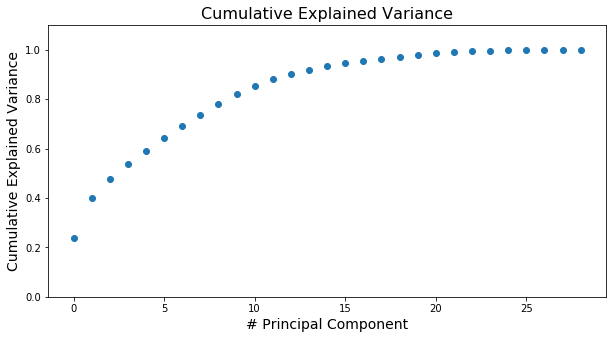

In [113]:
# Perform PCA on train data for dimensionality reduction
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Calculate cumulative explained variance
cumulative_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Visualize the explained variance percentages
fig, ax = plt.subplots(figsize=(10,5))

# Plot the Cumulative Explained Variance Percentage for all Principal Components
ax.scatter(np.arange(len(X_train.columns)), cumulative_explained_variance_ratio)
ax.set_title("Cumulative Explained Variance", fontsize=16)
ax.set_ylabel("Cumulative Explained Variance", fontsize=14)
ax.set_xlabel("# Principal Component", fontsize=14)
ax.set_ylim([0,1.1])
plt.show()

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

model = DecisionTreeClassifier()

cv_scores = cross_val_score(model, X_train_scaled_pca[:,(1,2)], y_train, scoring='f1_weighted', cv=10)
cv_mean = cv_scores.mean()
cv_mean

0.35680819180819184

In [171]:
scores = []
pc_ids = []

main_comb = (10, 27, 9)
C = []

principal_component_ids = np.arange(X_train.shape[1])

for i in range(len(principal_component_ids)):
    if i not in main_comb:
        combination = main_comb + (i,)
    
        C.append(combination)
#         pc_ids.append(pc_id)

        model = DecisionTreeClassifier(random_state=327)

        cv_scores = cross_val_score(model, X_train_scaled_pca[:, combination], y_train, scoring='precision_micro', cv=10)
        cv_mean = cv_scores.mean()
        
        scores.append(cv_mean)

In [172]:
results = pd.DataFrame.from_dict({'Principal Components':C, 
                        'scores':scores}).sort_values(by='scores', ascending=False)

results.head()

,Principal Components,scores
24,"(10, 27, 9, 26)",0.507692
11,"(10, 27, 9, 13)",0.452564
21,"(10, 27, 9, 23)",0.445513
5,"(10, 27, 9, 5)",0.429487
16,"(10, 27, 9, 18)",0.423718


In [182]:
# Step 4. Initialise model parameters
hidden_neurons = 20
learning_rate = 0.4
num_epoch = 200

combination = (9,10,26,27)

# Step 5. Build model skeleton



net, loss_func, optimiser = create_model(hidden_neurons=hidden_neurons,
                                         learning_rate=learning_rate,
                                         num_epoch=num_epoch)

# Step 6. Train the model and store build history
losses = train_neural_network(net, X_train_scaled_pca[:, combination], y_train)

# # Step 7. Evaluate on train and test data
x_train = X_train_scaled_pca[:, combination]
evaluate(net, x_train, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_scaled_pca = pca.transform(X_test_scaled)
x_test = X_test_scaled_pca[:, combination]

evaluate(net, x_test, y_test, mode='Test')

Training Accuracy = 45.3125%
Confusion matrix for Training:
[[28.  5. 10.]
 [18.  6. 19.]
 [12.  6. 24.]]

Classification Report -
              precision    recall  f1-score   support

           0       0.48      0.65      0.55        43
           1       0.35      0.14      0.20        43
           2       0.45      0.57      0.51        42

    accuracy                           0.45       128
   macro avg       0.43      0.45      0.42       128
weighted avg       0.43      0.45      0.42       128

Testing Accuracy = 42.42424392700195%
Confusion matrix for Testing:
[[9. 0. 2.]
 [5. 2. 4.]
 [5. 3. 3.]]

Classification Report -
              precision    recall  f1-score   support

           0       0.47      0.82      0.60        11
           1       0.40      0.18      0.25        11
           2       0.33      0.27      0.30        11

    accuracy                           0.42        33
   macro avg       0.40      0.42      0.38        33
weighted avg       0.40      0.4

In [187]:
X_train.describe()

,Time_to_firstclick,Fixation_count,Fixation_loss,Log_completionD,Page_visit,Wrong_answer,Clicked_link,Scrolled,Minimal_scanpath_value,Complete,...,Trackback,Task_satisfaction,TaskNum_t1,TaskNum_t2,TaskNum_t3,TaskNum_t4,TaskNum_t5,TaskNum_t6,TaskNum_t7,TaskNum_t8
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,...,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000
mean,9.266883,25.992188,0.226562,1.296752,1.054688,0.046875,1.476562,0.187500,2.406250,0.976562,...,1.460938,4.875000,0.117188,0.109375,0.101562,0.109375,0.132812,0.125000,0.093750,0.117188
std,6.345256,20.869107,0.785848,0.231198,0.228263,0.212202,0.878123,0.391846,1.282453,0.151883,...,1.303553,1.430819,0.322907,0.313335,0.303259,0.313335,0.340705,0.332018,0.292626,0.322907
min,1.399000,2.000000,0.000000,0.927319,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.216500,11.000000,0.000000,1.136648,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,...,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.049000,19.000000,0.000000,1.253817,1.000000,0.000000,1.000000,0.000000,2.000000,1.000000,...,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.236750,34.750000,0.000000,1.386761,1.000000,0.000000,2.000000,0.000000,3.000000,1.000000,...,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,34.809000,103.000000,5.000000,2.170291,2.000000,1.000000,5.000000,1.000000,8.000000,1.000000,...,7.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


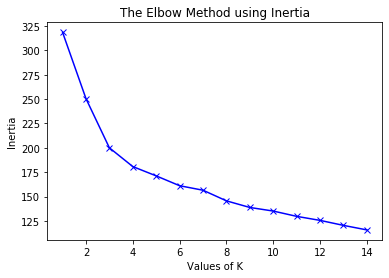

In [218]:
from sklearn.cluster import KMeans

inertias = [] 
K = range(1,15) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_train_scaled)     
      
    inertias.append(kmeanModel.inertia_) 

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
# plt.vlines(x=4, ymin=0, ymax=20000)
plt.show() 

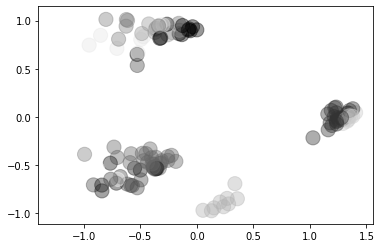

In [266]:
k=int(128 ** 0.5)

kmeanModel = KMeans(n_clusters=k)
kmeanModel.fit(X_train_scaled)    

clusters = kmeanModel.predict(X_train_scaled)

plt.scatter(X_train_scaled_pca[:,0], X_train_scaled_pca[:,1], c=clusters, cmap='gray', s=200, alpha=0.4)

In [264]:
k= int(128 ** 0.5)

kmeanModel = KMeans(n_clusters=k)
kmeanModel.fit(X_train_scaled)    

clusters = kmeanModel.predict(X_train_scaled)

m = np.array(list(zip(y_train.values, clusters)))

total = m.shape[0]
print("Total number of observations = ", total)

targets = {i:[] for i in np.arange(k)}

for y, c in m:
    
    targets[y].append(c)
    
    for i in np.arange(k):
        if i != y:
            targets[i].append(np.nan)

df = pd.DataFrame(targets)

for col in df:
    print(df[col].value_counts())

Total number of observations =  128
6.0     10
8.0      8
10.0     5
9.0      4
3.0      4
5.0      3
1.0      2
0.0      2
2.0      2
4.0      2
7.0      1
Name: 0, dtype: int64
7.0     8
9.0     7
6.0     6
10.0    5
0.0     4
8.0     4
5.0     2
1.0     2
2.0     2
4.0     2
3.0     1
Name: 1, dtype: int64
6.0     9
2.0     7
10.0    6
1.0     4
3.0     4
7.0     3
4.0     3
9.0     2
0.0     2
5.0     2
Name: 2, dtype: int64
Series([], Name: 3, dtype: int64)
Series([], Name: 4, dtype: int64)
Series([], Name: 5, dtype: int64)
Series([], Name: 6, dtype: int64)
Series([], Name: 7, dtype: int64)
Series([], Name: 8, dtype: int64)
Series([], Name: 9, dtype: int64)
Series([], Name: 10, dtype: int64)
